### Imports & Settings

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import datetime

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

RANDOM_STATE = 42
OUTPUT_DIR = "models"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


### Load features

In [2]:
# Cell 2 — load prepared features
hr_features_path = r"features/hr_features.csv"
print("Loading:", hr_features_path)
hr = pd.read_csv(hr_features_path)

# Inspect
print("Shape:", hr.shape)
hr.head()


Loading: features/hr_features.csv
Shape: (1470, 49)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Flag
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,False,False,False,False,True,False,False,True,True,1
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,False,False,False,True,False,False,True,False,False,0
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,False,False,False,False,False,False,False,True,True,1
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,False,False,False,True,False,False,True,False,True,0
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,False,False,False,False,False,False,True,False,False,0


### Prepare X, y

In [3]:
# Cell 3 — prepare X and y
# Try common column names for target
if 'Attrition_Flag' in hr.columns:
    target_col = 'Attrition_Flag'
elif 'Attrition' in hr.columns:
    # map if necessary
    hr['Attrition_Flag'] = hr['Attrition'].map({'Yes':1, 'No':0})
    target_col = 'Attrition_Flag'
else:
    raise ValueError("Target column not found. Expected 'Attrition_Flag' or 'Attrition' mapping.")

y = hr[target_col].astype(int)
X = hr.drop(columns=[col for col in [target_col, 'Attrition'] if col in hr.columns])

print("X shape:", X.shape, "y distribution:\n", y.value_counts(normalize=True))


X shape: (1470, 48) y distribution:
 Attrition_Flag
0    0.838776
1    0.161224
Name: proportion, dtype: float64


### Train / Test Split

In [4]:
# Cell 4 — stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1176, 48) Test: (294, 48)


### Baseline models - pipeline + training

In [5]:
# Cell 5 — build pipelines and train baseline models
from sklearn.compose import ColumnTransformer

# Simple imputer + scaler pipeline to apply to numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols)
    ],
    remainder="passthrough"  # categorical dummies already encoded in features
)

# Define models
models = {
    "logistic": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "random_forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
}
if XGBOOST_AVAILABLE:
    models["xgboost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1)

fitted_models = {}

for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    print("Training:", name)
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    print("Done:", name)


Training: logistic
Done: logistic
Training: random_forest
Done: random_forest


### Evaluate models

--- logistic ---
Accuracy: 0.8639
Precision: 0.64
Recall: 0.3404
F1: 0.4444
ROC-AUC: 0.8095

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.64      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.76      0.65      0.68       294
weighted avg       0.85      0.86      0.85       294



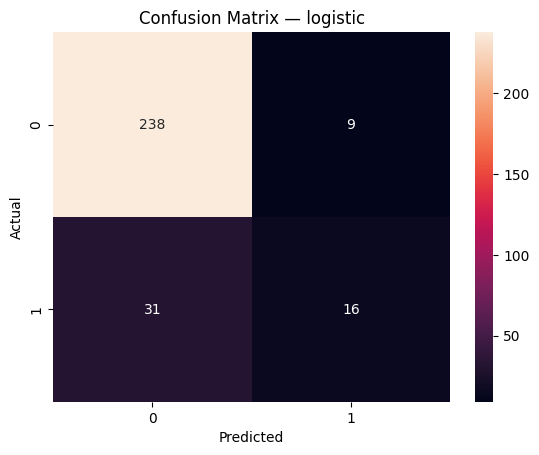

--- random_forest ---
Accuracy: 0.8367
Precision: 0.4615
Recall: 0.1277
F1: 0.2
ROC-AUC: 0.7936

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.46      0.13      0.20        47

    accuracy                           0.84       294
   macro avg       0.66      0.55      0.55       294
weighted avg       0.79      0.84      0.80       294



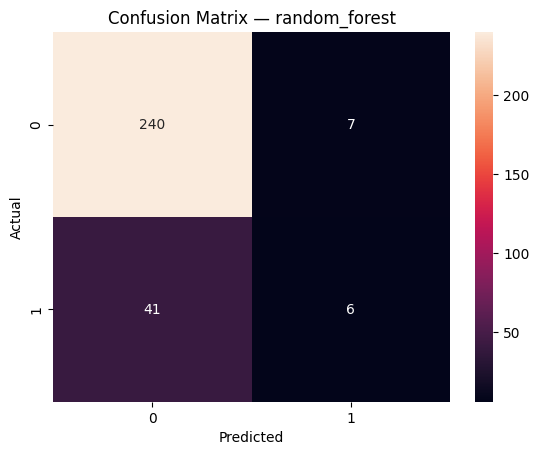

,accuracy,precision,recall,f1,auc
logistic,0.863946,0.640000,0.340426,0.444444,0.809544
random_forest,0.836735,0.461538,0.127660,0.200000,0.793608


In [6]:
# Cell 6 — evaluate on test set
def eval_model(pipe, X_test, y_test, model_name="model"):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"--- {model_name} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1:", round(f1,4))
    print("ROC-AUC:", round(auc,4))
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "auc":auc}

results = {}
for name, pipe in fitted_models.items():
    results[name] = eval_model(pipe, X_test, y_test, name)

pd.DataFrame(results).T


### Feature importance (for tree models)

Top features — random_forest


MonthlyIncome               0.065293
Age                         0.061096
TotalWorkingYears           0.053259
DailyRate                   0.049424
MonthlyRate                 0.044567
HourlyRate                  0.043750
EmployeeNumber              0.043114
DistanceFromHome            0.042869
OverTime_Yes                0.036173
TenureMonths                0.034941
YearsAtCompany              0.033591
PercentSalaryHike           0.033204
NumCompaniesWorked          0.032642
YearsWithCurrManager        0.032144
EnvironmentSatisfaction     0.026224
WorkLifeBalance             0.025505
YearsInCurrentRole          0.024466
StockOptionLevel            0.024132
RelationshipSatisfaction    0.023139
TrainingTimesLastYear       0.022844
dtype: float64

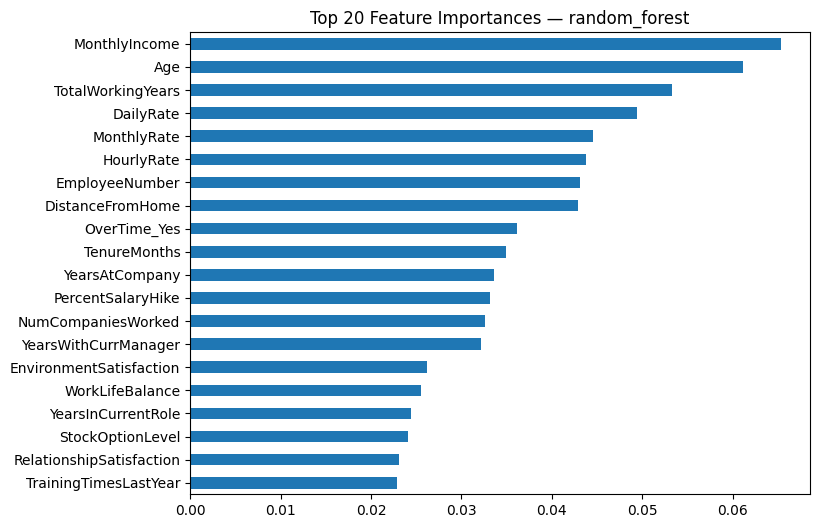

In [7]:
# Cell 7 — feature importance for random forest / xgboost
feature_names = numeric_cols + [c for c in X.columns if c not in numeric_cols]

def get_feature_importances(pipe, model_key):
    clf = pipe.named_steps['clf']
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        # If preprocessor 'remainder' passed columns through, ColumnTransformer may reorder — using transformed feature count equal to X.shape[1]
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(50)
        return fi
    else:
        return None

for name in ["random_forest", "xgboost"]:
    if name in fitted_models:
        fi = get_feature_importances(fitted_models[name], name)
        if fi is not None:
            print("Top features —", name)
            display(fi.head(20))
            plt.figure(figsize=(8,6))
            fi.head(20).plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.title(f"Top 20 Feature Importances — {name}")
            plt.show()


### Hyperparameter tuning (short Grid)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
--- random_forest_tuned ---
Accuracy: 0.8367
Precision: 0.4545
Recall: 0.1064
F1: 0.1724
ROC-AUC: 0.7755

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.45      0.11      0.17        47

    accuracy                           0.84       294
   macro avg       0.65      0.54      0.54       294
weighted avg       0.79      0.84      0.79       294



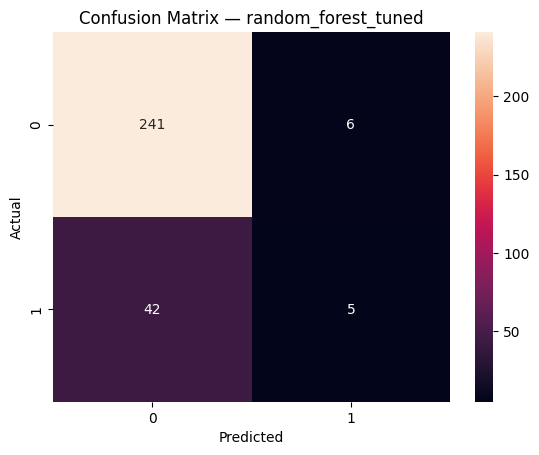

In [8]:
# Cell 8 — quick grid search for RandomForest (short)
param_grid = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 8],
    "clf__min_samples_split": [2, 5]
}

rf_pipe = Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(rf_pipe, param_grid, cv=cv, n_jobs=-1, scoring="f1", verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_
results["random_forest_tuned"] = eval_model(best_rf, X_test, y_test, "random_forest_tuned")
fitted_models["random_forest_tuned"] = best_rf


### Save best model

In [9]:
# Cell 9 — choose best model by F1 on test set and save
best_name = max(results.items(), key=lambda kv: kv[1]['f1'])[0]
best_model = fitted_models[best_name]
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(OUTPUT_DIR, f"attrition_model_{best_name}_{timestamp}.pkl")
joblib.dump(best_model, save_path)
print("Saved best model:", best_name, "to", save_path)


Saved best model: logistic to models\attrition_model_logistic_20251202_221211.pkl


### Calibration & Probability threshold tuning

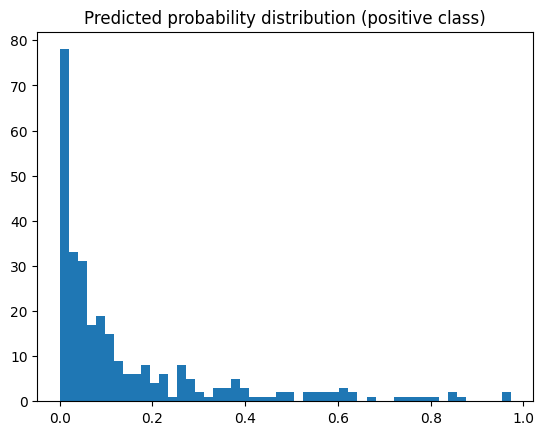

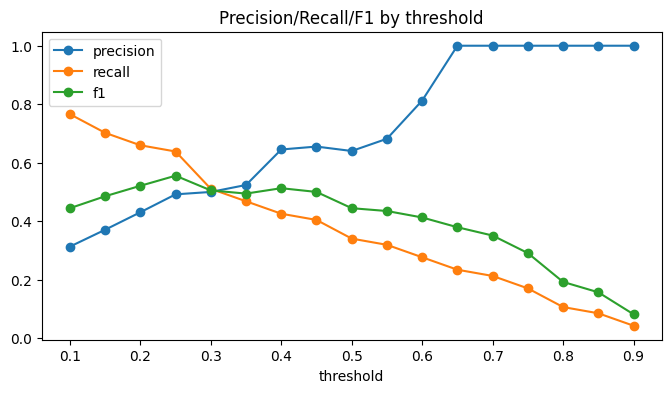

In [10]:
# Cell 10 — check predicted probabilities distribution and consider threshold change
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(X_test)[:,1]
    plt.hist(probs, bins=50)
    plt.title("Predicted probability distribution (positive class)")
    plt.show()

    # Example: compute metrics for multiple thresholds
    thresholds = np.linspace(0.1, 0.9, 17)
    records = []
    from sklearn.metrics import precision_recall_curve
    for t in thresholds:
        preds = (probs >= t).astype(int)
        records.append({
            "threshold": t,
            "precision": precision_score(y_test, preds, zero_division=0),
            "recall": recall_score(y_test, preds, zero_division=0),
            "f1": f1_score(y_test, preds, zero_division=0)
        })
    pd.DataFrame(records).set_index("threshold").plot(marker='o', figsize=(8,4))
    plt.title("Precision/Recall/F1 by threshold")
    plt.show()
